# Multiagent systems - TSP Problem

In [193]:
import tsplib95
from random import randrange, random, shuffle
from bisect import bisect
import pandas as pd
import matplotlib.pyplot as plt

## Load TSP Problem

In [89]:
# Data Source : http://www.math.uwaterloo.ca/tsp/world/countries.html
TSP_FILE = 'uy734.tsp' # 🇺🇾 Uruguay
TSP_FILE = 'wi29.tsp' # 🇪🇭 Western Sahara

In [90]:
# LOAD TSP FILE
PROBLEM = tsplib95.load(TSP_FILE)
print(type(PROBLEM))

<class 'tsplib95.models.StandardProblem'>


In [91]:
PROBLEM.type

'TSP'

In [92]:
N = len(list(PROBLEM.get_nodes())) # N is total cities
print("%s Cities"%N)

29 Cities


In [93]:
# Example city coordinates
PROBLEM.node_coords[3]

[21300.0, 13016.6667]

In [94]:
# Distance between first and last cities
edge = {'start':1,'end':N}
PROBLEM.get_weight(**edge)

7799

## Basic Ant

In [183]:
class Ant:
    tour = None
    tsp = PROBLEM
    _tour_weight_cache = {'n_cities':0, 'weight': 0} # code optimization
    
    def __init__(self, city_i=0):
        self.tour = []
        if city_i>0:
            self.visit(city_i)
    
    @property
    def current_city(self):
        return self.tour[-1]

    @property
    def tour_weight(self):
        if len(self.tour) != self._tour_weight_cache['n_cities']:
            self._tour_weight_cache['weight'] = self.tsp.trace_tours([self.tour])[0]
        return self._tour_weight_cache['weight']
    
    def visit(self, i:int):
        if i in self.tour:
            raise Exception("The city i: %s is already visited. Imposible to visit again"%i)
        if i < 1 or i > N:
            raise Exception("The city i (%s) is out of range: -> [1, %s]"%(i, N))
        self.tour.append(i)
    
    def distance_to(self, city_j:int):
        return self.tsp.get_weight(self.current_city, city_j)
    
    def _not_visited_cities(self):
        return [i for i in range(1,N+1) if i not in self.tour]
    
    def _raw_probability(self, city_j:int, pheromones_matrix):
        ## ASSUMPTION: We consider the edge has two ways. Phromones to go and to go back. In other words. I->J != J->I
        # careful, we must substract one from the cities index
        return pheromones_matrix[self.current_city-1][city_j-1]**ALPHA * (1/self.distance_to(city_j))**BETA
    
    def normalized_probabilities(self, pheromones_matrix):
        """ Returns a tuple
            First element: List of neighbors, cities not visited
            Second element: List of probabilities calculated with the formular of tau_ij^A* h_ij^B
        """
        neighbors = self._not_visited_cities()
        neighbors_pheromone_list = [self._raw_probability(neighbor_j, pheromones_matrix) for neighbor_j in neighbors]
        total = sum(neighbors_pheromone_list)
        return neighbors, [pheromone_ij/total for idx, pheromone_ij in enumerate(neighbors_pheromone_list)]
        
    def pick_next_city(self, cities, probabilities):
        roulette_x = random()
        idx = bisect(probabilities, roulette_x)
        #print('idx', idx-1)
        #print('cities', cities)
        return cities[idx-1]
    
    def finished_tour(self):
        return len(self.tour) == N

    def plot_hot_map(self):
        df = pd.DataFrame([[0 for j in N] for i in N])
        for posi_i in range(1, len(ant.tour)):
            i = ant.tour[posi_i-1]-1
            j = ant.tour[posi_i]-1
            pheromones_to_add[i][j] += tau_delta
            
        plt.imshow(df, cmap='hot', interpolation='nearest')
        plt.show()

In [184]:
a = Ant(1)
print(a.tour)
a.visit(29)
print(a.tour)
print("Total weight of this ant tour is: %s"%a.tour_weight)

[1]
[1, 29]
Total weight of this ant tour is: 15598


## BASE LINE

In [200]:
# Solution joining all the cities in sequence
ant = Ant(1)
for i in range(2,N+1):
    ant.visit(i)
print(ant.tour)
print(ant.tour_weight)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
52284


In [204]:
# Random Solution
ant = Ant(1)
random_cities = list(range(2,N+1))
shuffle(random_cities)
for i in random_cities:
    ant.visit(i)
print(ant.tour)
print(ant.tour_weight)

[1, 15, 6, 2, 22, 12, 3, 27, 10, 4, 21, 8, 19, 20, 17, 16, 18, 14, 23, 7, 25, 9, 5, 11, 13, 29, 26, 28, 24]
108265


In [222]:
# Solution using the heuristic
ant = Ant(1)
while not ant.finished_tour():
    neighbors = ant._not_visited_cities()
    distances = []
    for city_j in range(1, len(neighbors)+1):
        distances.append(ant.distance_to(city_j))
    pos_min_distance = distances.index(min(distances))
    next_closest_city = neighbors[pos_min_distance]
    ant.visit(next_closest_city)
print(ant.tour)
print(ant.tour_weight)

[1, 2, 4, 7, 11, 16, 22, 29, 28, 27, 23, 26, 25, 24, 20, 21, 19, 18, 17, 14, 15, 13, 12, 8, 9, 6, 5, 10, 3]
56645


## ANT SYSTEM

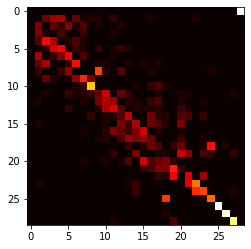

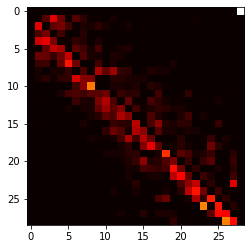

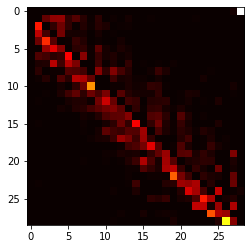

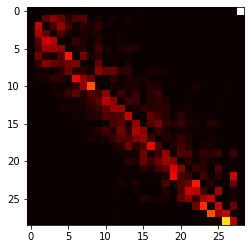

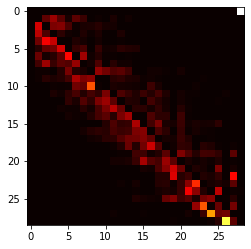

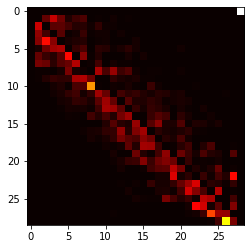

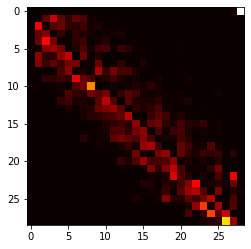

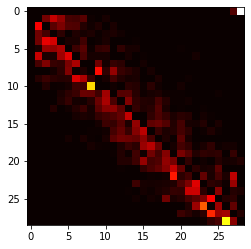

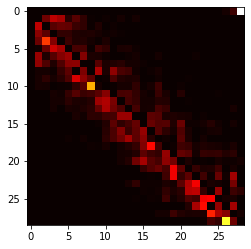

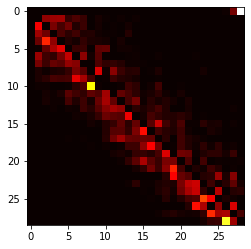

In [210]:
M_ANTS = N # Number of ants ~ to number of nodes (N)
ALPHA = 1 # History coefficietn ~ 1
BETA = 2.5 # 0,1,2,3,4,5,6 # Heuristic Coefficient [2,5]
RO = 0.5 # Evaporation rate # It's like cooling. A high value is similar to very decrease the temparature drastically and get stucked in a local optimum
Q = 1 # Pheromone change factor
TAU_INITIAL = 1/70000 # Initial pheromone ~ 1/RO*C^nn ; C^nn is the length of the tour generated by the nearest neighbor heuristic
STEPS = 10000

# INIT MATRIX for each CITY IJ with TAU INITIAL (t_0)
_pheromones_row = [TAU_INITIAL for i in range(N)]
pheromones_matrix = [_pheromones_row for j in range(N)]
    
for step in range(STEPS):
    ants_list = []
    for ant_i in range(M_ANTS):
        # pick a starting point
        first_random_city = randrange(N)+1
        ant = Ant(1)
        ants_list.append(ant)
        while not ant.finished_tour():
            # calculate probability P_j for all unvisited neightbors J
                # ANT SYSTEM (AS): Probability of each edge in the neighborhood
                # p_ij_k = (t_ij^a * (1/d_ij)^b ) / SUM(all feasible g edges) # It's like edge normalized
            neighbors, probabilities = ant.normalized_probabilities(pheromones_matrix) # sum(probabilities) == 1
            # pick the next node using the probabilities
            next_city = ant.pick_next_city(neighbors, probabilities)
            ant.visit(next_city)
    # update pheromone values based upon the quality of each solution
        # ANT SYSTEM (AS): All ants contribute updating the pheromone as follows
        # TAU_I_J = (1-RO)*TAU_I_J + SUM(Q/(Lk or 0)) # Attention! In TSP Lk will be always the same == N Total cities
                                           # Probably in TSP the length means the distance
    pheromones_to_add = [[0 for i in range(N)] for j in range(N)]
    for ant in ants_list:
        tau_delta = Q/ant.tour_weight
        for tour_i in range(1, len(ant.tour)+1):
            i = ant.tour[tour_i-1]-1
            j = ant.tour[tour_i]-1
            pheromones_to_add[i][j] += tau_delta
    
    # PLOT
    if step % int(STEPS/10) == 0:
        print("Step %s from %s."%(step,STEPS))
        df = pd.DataFrame(pheromones_matrix)*(1-RO)+pd.DataFrame(pheromones_to_add)
        pheromones_matrix = df.values
        plt.imshow(df, cmap='hot', interpolation='nearest')
        plt.show()

In [217]:
tours_weight_list = [a.tour_weight for a in ants_list]
print(tours_weight_list)

[80313, 72534, 73654, 67740, 66549, 71701, 75478, 72029, 75011, 82153, 78634, 75429, 67141, 72711, 77966, 73597, 71112, 78222, 73925, 66521, 64373, 70903, 65873, 68877, 73046, 76144, 69145, 65238, 68166]


In [219]:
pos_min = tours_weight_list.index(min(tours_weight_list))
print("Min weigth: %s"%tours_weight_list[pos_min])
print("Tour: %s"%ants_list[pos_min].tour)

Min weigth: 64373
Tour: [1, 29, 27, 28, 26, 25, 24, 23, 22, 20, 21, 16, 19, 17, 15, 18, 14, 13, 11, 9, 12, 10, 3, 8, 7, 2, 4, 6, 5]


2

## Parameters

In [95]:
M_ANTS = 5 # Number of ants ~ to number of nodes (N)
ALPHA = 1 # History coefficietn ~ 1
BETA = 2 # 0,1,3,4,5,6 # Heuristic Coefficient [2,5]
RO = 0.02 # Eaporation rate # It's like cooling. A high value is similar to very decrease the temparature drastically and get stucked in a local optimum
Q = 0.5 # Pheromone change factor
TAU_INITIAL = 0.5 # Initial pheromone ~ 1/RO*C^nn ; C^nn is the length of the tour generated by the nearest neighbor heuristic

In [96]:
# FOR MMAS
CHS = 99999999999 # TODO: Make the heuristic picking the shortest path at each step
TAU_MAX = 1/(RO*CHS) # 1/RO*C^hs ; C^hs is the length of the best tour found so far
TAU_MIN = TAU_MAX*(1-0.05**(1/N))